In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import re
from tqdm import tqdm
from transformers import AutoTokenizer
model_ckpt = "tohoku-nlp/bert-base-japanese"
from torch.utils.data import Dataset, DataLoader
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/ryozawau/anaconda3/envs/jupyterbook/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
wrime = pd.read_csv('/media/lyuzeyu_hdd/css_nlp/notebook/Data/wrime-ver2.tsv', sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: '/media/lyuzeyu_hdd/css_nlp/notebook/Data/wrime-ver2.tsv'

In [4]:
wrime.head()

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Sentiment,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust,Avg. Readers_Sentiment
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,1,2012/7/31 23:48,train,0,1,2,1,1,0,...,-1,0,2,0,0,0,0,0,0,-1
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,1,2012/8/2 23:09,train,3,0,3,0,0,0,...,1,1,0,0,2,0,0,0,0,1
2,早寝するつもりが飲み物がなくなりコンビニへ。ん、今日、風が涼しいな。,1,2012/8/5 0:50,train,1,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,0
3,眠い、眠れない。,1,2012/8/8 1:36,train,0,2,1,0,0,1,...,-1,0,1,0,0,0,0,1,0,-1
4,ただいま〜 って新体操してるやん!外食する気満々で家に何もないのに!テレビから離れられない…!,1,2012/8/9 22:24,train,2,1,3,2,0,1,...,0,1,0,0,1,0,0,0,0,0


In [5]:
wrime["Avg. Readers_Sentiment"].value_counts()

Avg. Readers_Sentiment
 0    11462
-1    10468
 1     9138
 2     2245
-2     1687
Name: count, dtype: int64

In [6]:
wrime["Train/Dev/Test"].value_counts()

Train/Dev/Test
train    30000
test      2500
dev       2500
Name: count, dtype: int64

In [7]:
train_df=wrime[wrime["Train/Dev/Test"]=="train"][["Sentence","Avg. Readers_Sentiment"]][:4000]
train_df.columns=["sentence","label"]

val_df=wrime[wrime["Train/Dev/Test"]=="dev"][["Sentence","Avg. Readers_Sentiment"]]
val_df.columns=["sentence","label"]

test_df=wrime[wrime["Train/Dev/Test"]=="test"][["Sentence","Avg. Readers_Sentiment"]]
test_df.columns=["sentence","label"]

In [8]:
train_df["text_length"]=train_df["sentence"].str.len()

<Axes: title={'center': 'text_length'}, xlabel='label'>

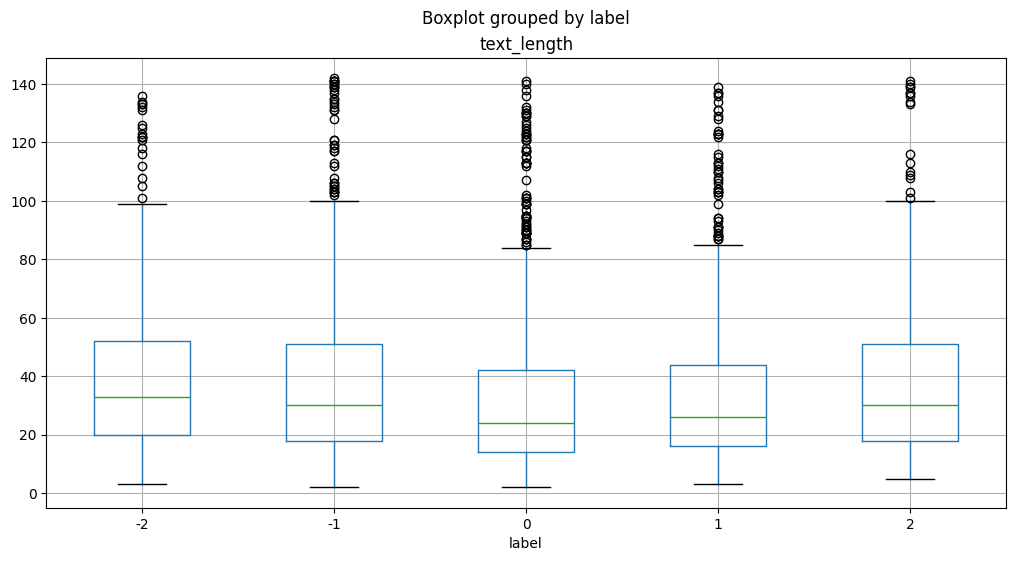

In [9]:
train_df.boxplot(column="text_length", by="label", figsize=(12, 6))


In [10]:
from transformers import AutoTokenizer
model_ckpt = "tohoku-nlp/bert-base-japanese"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
def create_dataset(df, pad_size, auto_tokenizer):
    tokenizer = AutoTokenizer.from_pretrained(auto_tokenizer)
    df["text"] = df["sentence"].astype(str)
    df["label"] = df["label"].astype(int)
    contents = []
    for index, rows in tqdm(df.iterrows(), total=df.shape[0]):
        text = rows["text"]
        label = rows["label"]
        # Remove URLs and mentions
        text = re.sub(r"(?:\@|https?\://)\S+\b", "", text)
        # Tokenize the text
        token = tokenizer(text, padding='max_length', truncation=True, max_length=pad_size, return_tensors="np")
        # Extract token ids and attention mask
        token_ids = token['input_ids'][0]
        attention_mask = token['attention_mask'][0]
        # Calculate sequence length (excluding padding)
        seq_len = sum(attention_mask)  # Sequence length is the sum of the attention mask
        contents.append((token_ids, int(label), seq_len, attention_mask))
    return contents

In [12]:
train=create_dataset(df=train_df, pad_size=150, auto_tokenizer=model_ckpt)
val=create_dataset(df=val_df, pad_size=150, auto_tokenizer=model_ckpt)
test=create_dataset(df=test_df, pad_size=150, auto_tokenizer=model_ckpt)

100%|██████████| 2500/2500 [00:00<00:00, 5284.78it/s]


In [13]:
class CustomDataset(Dataset):
    def __init__(self, data, device):
        self.data = data
        self.device = device
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        token_ids, label, seq_len, mask = self.data[idx]
        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long).to(self.device),
            'label': torch.tensor(label, dtype=torch.long).to(self.device),
            'seq_len': torch.tensor(seq_len, dtype=torch.long).to(self.device),
            'attention_mask': torch.tensor(mask, dtype=torch.long).to(self.device)
        }

In [14]:
train_dataset = CustomDataset(train, device=device)
val_dataset = CustomDataset(val, device=device)
test_dataset = CustomDataset(test, device=device)

In [15]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 5

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

2025-01-06 19:33:08.227619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 19:33:08.233937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-06 19:33:08.241592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-06 19:33:08.244020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 19:33:08.250620: I tensorflow/core/platform/cpu_feature_guar

In [16]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [17]:

from transformers import TrainingArguments

batch_size = 16
logging_steps = len(train_dataset) // batch_size
model_name = "wrime-text-classification-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="steps",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

/home/lvzeyu/anaconda3/envs/nlp/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)


/tmp/ipykernel_552654/2159861020.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()